In [17]:
from modules.dataloader import get_loaders
import torch
import matplotlib.pyplot as plt
from torchvision import models

In [16]:
from nvidia.dali import ops

In [19]:
ops.Resize(device='gpu')

<nvidia.dali.ops.python_op_factory.<locals>.Operator at 0x7f3369c27da0>

In [15]:
import numpy
N = 6
BS = 2
ar = np.round(np.random.rand(N), 2)
print(ar)
ar.sort()
print(ar)
for i in range(N//BS):
    ar[i*BS:(i+1)*BS] = ar[i*BS:(i+1)*BS].mean()
ar

[0.73 0.8  0.66 0.43 0.91 0.97]
[0.43 0.66 0.73 0.8  0.91 0.97]


array([0.545, 0.545, 0.765, 0.765, 0.94 , 0.94 ])

In [2]:
from __future__ import print_function, with_statement, division
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean): if this flag is set to True, `state_dict` of model and
            optimizer will be cached in memory. Otherwise, they will be saved to files
            under the `cache_dir`.
        cache_dir (string): path for storing temporary files. If no path is specified,
            system-wide temporary directory is used.
            Notice that this parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store('model', self.model.state_dict())
        self.state_cacher.store('optimizer', self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""
        self.model.load_state_dict(self.state_cacher.retrieve('model'))
        self.optimizer.load_state_dict(self.state_cacher.retrieve('optimizer'))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
        """
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iterator = iter(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Get a new set of inputs and labels
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)

            # Train on batch and retrieve loss
            loss = self._train_batch(inputs, labels)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _train_batch(self, inputs, labels):
        # Set model to training mode
        self.model.train()

        # Move data to the correct device
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Plot loss as a function of the learning rate
        plt.plot(lrs, losses)
        if log_lr:
            plt.xscale("log")
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.show()


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile
            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError('Given `cache_dir` is not a valid directory.')

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, 'state_{}_{}.pt'.format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError('Target {} was not cached.'.format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError('Failed to load state in {}. File does not exist anymore.'.format(fn))
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""
        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])

/usr/local/lib/python3.5/dist-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
model = models.mobilenet_v2()
DIR = '/home/zakirov/datasets/imagenet_2012/raw_data/'
train_loader,val_loader, _,_ = get_loaders(DIR+'train', DIR+'validation', bs=128, val_bs=128, sz=224, workers=8, distributed=False)

In [5]:
len(val_loader)

391

In [13]:
optim = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-5)
loss = torch.nn.CrossEntropyLoss()

In [16]:
lrfinder = LRFinder(model.cuda(), optim, loss)
lrfinder.range_test(val_loader, num_iter=min([200, len(val_loader)]))


Learning rate search finished. See the graph with {finder_name}.plot()


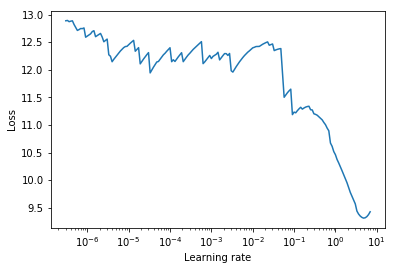

In [17]:
lrfinder.plot()

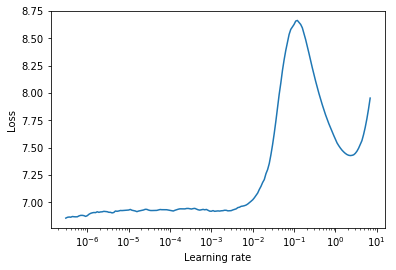

In [15]:
lrfinder.plot()

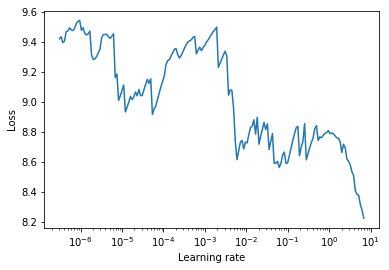

In [11]:
lrfinder.plot()

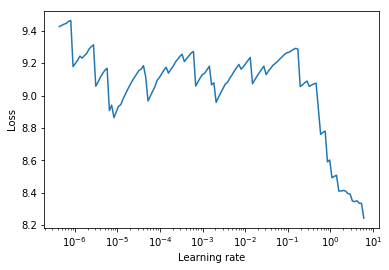

In [9]:
lrfinder.plot()

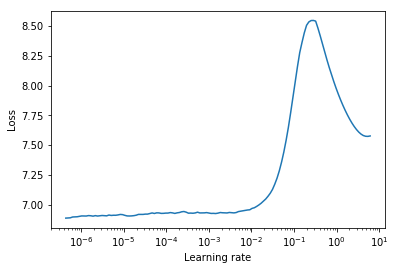

In [36]:
lrfinder.plot()